### 0. Imports necesarios

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgb
import os
import dill
import warnings


### 1. Carga de datos de Test e identificación de columnas

In [8]:
df_test = pd.read_csv('../data/test.csv', index_col=0)

# Ponemos 'id' como índice
df_test = df_test.set_index('id')

### 2. Comprobamos que el .pkl trae todo lo que necesitamos

In [9]:
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODEL_DIR = os.path.join(BASE_PATH, "models")
model_path = os.path.join(MODEL_DIR, "best_pipeline.pkl")

with open(model_path, "rb") as f:
    best_pipeline = dill.load(f)

print(best_pipeline)

Pipeline(steps=[('null_handling',
                 Pipeline(steps=[('drop_high_nulls', DropHighNullColumns()),
                                 ('drop_remaining_nulls', DropRemainingNulls()),
                                 ('drop_duplicates', DropDuplicates())])),
                ('column_identification', IdentifyColumns()),
                ('log_transform',
                 FunctionTransformer(func=<function safe_log_transform at 0x0000012371B86A20>)),
                ('preprocessor',
                 Pipeline(steps=[('pr...
                                                                    'boarding',
                                                                    'Seat '
                                                                    'comfort',
                                                                    'Inflight '
                                                                    'entertainment',
                                                                  

### 3. Aplicamos los pipelines

In [10]:
# Filtrar FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Se asume que 'df_test' ya está cargado y tiene 'id' como índice.
y_test = df_test["satisfaction"].replace({"neutral or dissatisfied": 0, "satisfied": 1}).infer_objects(copy=False)
X_test = df_test.drop(columns=["satisfaction"])

# Añadir la columna dummy 'satisfaction' para que el pipeline procese los datos igual que en entrenamiento
X_test_pipeline = X_test.copy()
X_test_pipeline["satisfaction"] = "neutral or dissatisfied"

# Recuperar la variable 'numerical_cols_log' desde el transformer 'column_identification'
numerical_cols_log = best_pipeline.named_steps["column_identification"].numerical_cols_log

# Obtener los índices de las filas que sobreviven la limpieza (nulos y duplicados)
X_test_clean = best_pipeline.named_steps["null_handling"].transform(X_test_pipeline)
idx_clean = X_test_clean.index

# Transformar hasta el preprocesador y remover la columna del target (posición 0)
X_test_transformed = best_pipeline[:-1].transform(X_test_pipeline)
X_test_final = X_test_transformed[:, 1:]

# Realizar las predicciones con el modelo entrenado
y_pred = best_pipeline.named_steps["model"].predict(X_test_final)

# Alinear y_test con los índices de las filas procesadas
y_test_aligned = y_test.loc[idx_clean]

print(f'¡Los pipelines se han aplicado correctamente!')

¡Los pipelines se han aplicado correctamente!


#### 4. Métricas de evaluación

Balanced Accuracy: 0.9482

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     14528
           1       0.96      0.93      0.94     11365

    accuracy                           0.95     25893
   macro avg       0.95      0.95      0.95     25893
weighted avg       0.95      0.95      0.95     25893



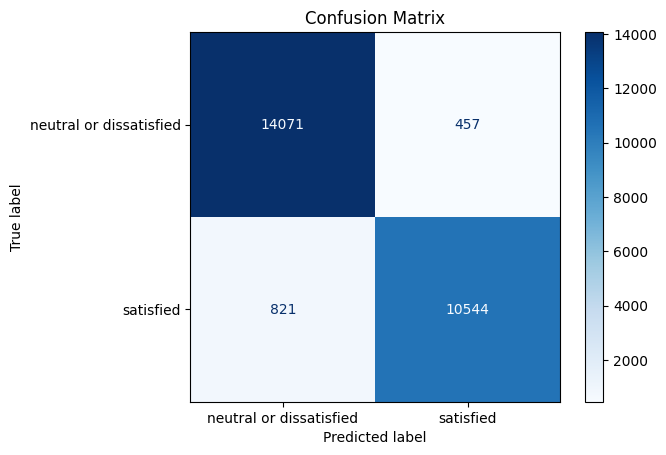

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Calcular Balanced Accuracy
acc = balanced_accuracy_score(y_test_aligned, y_pred)

# Mostrar métricas de evaluación
print(f"Balanced Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test_aligned, y_pred))

# Calcular y pintar la matriz de confusión
cm = confusion_matrix(y_test_aligned, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral or dissatisfied", "satisfied"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# Importancia de características (solo para modelos de árboles)

    # Crear un DataFrame ordenado por importancia
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(20)  # Mostrar solo las 20 más importantes

    # Graficar la importancia de características
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="Blues_r")

    # Etiquetas y título
    plt.title(f"Importancia de Características - {best_model_name}", fontsize=14)
    plt.xlabel("Importancia", fontsize=12)
    plt.ylabel("Características", fontsize=12)

    # Ajustar etiquetas para mejor legibilidad
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Mostrar valores sobre las barras
    for index, value in enumerate(feature_importance_df["Importance"]):
        plt.text(value + 2, index, f"{value:.2f}", fontsize=10, verticalalignment="center")

    plt.show()